In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from sklearn.linear_model import LogisticRegression
from scipy.stats import multivariate_normal
from scipy.special import expit
from sklearn.metrics import accuracy_score
import math
from numpy import linalg as LA
from numpy.linalg import inv
import math
import copy
import time
import statistics as stat
import warnings
import random

warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [334]:
# read datasets

A_X = pd.read_csv(r"pp3data/A.csv",header = None)
A_y = pd.read_csv(r"pp3data/labels-A.csv",header = None)

B_X = pd.read_csv(r"pp3data/B.csv",header = None)
B_y = pd.read_csv(r"pp3data/labels-B.csv",header = None)

irls_X = pd.read_csv(r"pp3data/irlstest.csv",header = None)
irls_y = pd.read_csv(r"pp3data/labels-irlstest.csv",header = None)

usps_X = pd.read_csv(r"pp3data/usps.csv",header = None)
usps_y = pd.read_csv(r"pp3data/labels-usps.csv",header = None)

In [335]:
# this function calculates the shared cov, mean for each class and the prior for each class

def generative_train(X_train, y_train):
    class_0  = X_train[y_train[0] == 0]
    class_1  = X_train[y_train[0] == 1]
    
    mean_0 = np.mean(class_0, axis = 0)
    prior_0 = len(class_0)/len(X_train)

    mean_1 = np.mean(class_1, axis = 0)
    prior_1 = len(class_1)/len(X_train)
    
    cov = X_train.cov() 
    cov = cov + (10**(-6))*np.identity((np.shape(cov)[0]))

    return mean_0, mean_1, prior_0, prior_1, cov

In [336]:
# this function return the predicted values for the generative model

def generative_test(X_test, mean_0, mean_1, prior_0, prior_1, cov):
    posterior_0 = prior_0*multivariate_normal.pdf(X_test, mean_0, cov)
    posterior_1 = prior_1*multivariate_normal.pdf(X_test, mean_1, cov)

    b = np.log((posterior_1/posterior_0))
    prob = [1 if a >= 0.5 else 0 for a in expit(b)]
    return prob

In [337]:
# this function calculates the wts using bayasian logistic regression using the Newton Method update method

def bayasian_logistic_reg(X, t):
    time_vector = []
    start_time = time.time()
    alpha = 0.1
    col = pd.DataFrame(np.ones((np.shape(X)[0],1)))
    
    # add the free w0 value
    X['bias'] = col

    w_old = np.zeros((np.shape(X)[1],1))
    time_vector.append((w_old, 0))
    
    # Newton method update
    b = np.dot(X, w_old)
    y = expit(b)
    a =   y*(1 - y)
    R = np.diagflat(a)
    mat = np.dot(np.dot((X.T),R),(X))
    w_new = w_old - (np.dot(inv(alpha*np.identity(np.shape(mat)[0]) + mat), (np.dot(X.T, y - t) + alpha*w_old)))
    time_vector.append((w_new, time.time() - start_time))
    n = 1
    while(((LA.norm(w_new - w_old) / LA.norm(w_old)) >= 10**(-3)) and (n <= 100)):
        w_old = w_new
        b = np.dot(X, w_old)
        y = expit(b)
        a =   y*(1 - y)
        R = np.diagflat(a)
        mat = np.dot(np.dot((X.T),R),X)
        w_new = w_old - (np.dot(inv(alpha*np.identity(np.shape(mat)[0]) + mat), (np.dot(X.T, y - t) + alpha*w_old)))
        time_vector.append((w_new, time.time() - start_time))
        n+=1

    return w_new, time_vector

In [338]:
# comparing weight values with the given solution

w, _ = bayasian_logistic_reg(irls_X, irls_y)
print(w)

[[-0.11937911]
 [-0.09438351]
 [-0.02868496]
 [-0.05118595]
 [-0.04410372]
 [ 0.65876598]
 [ 0.56470193]
 [ 0.82406586]
 [ 0.54141515]
 [ 0.27195451]
 [-1.63083174]]


In [339]:
# Calculating train size vs accuracy for dataset A.

a_gen = {}
a_dis = {}
b_gen = {}
b_dis = {}
usps_gen = {}
usps_dis = {}

for i in range(30):
    #print(i)
    A_X_train, A_X_test, A_y_train, A_y_test = train_test_split(A_X, A_y, test_size=(1/3))
    A_X_train.reset_index(drop = True, inplace = True)
    A_X_test.reset_index(drop = True, inplace = True)
    A_y_train.reset_index(drop = True, inplace = True) 
    A_y_test.reset_index(drop = True, inplace = True)
    
    for train_size in range(65, len(A_X_train), 50):
        mean_0, mean_1, prior_0, prior_1, cov = generative_train(A_X_train[0:train_size].reset_index(drop = True), A_y_train[0:train_size].reset_index(drop = True))
        res = generative_test(A_X_test, mean_0, mean_1, prior_0, prior_1, cov) 
        #print(train_size)
        if(train_size in a_gen):
            a_gen[train_size].append( accuracy_score(res, A_y_test))
        else:
            a_gen[train_size] = [accuracy_score(res, A_y_test)]
            
    col = pd.DataFrame(np.ones((np.shape(A_X_test)[0],1)))
    A_X_test['bias'] = col
    
    for train_size in range(65, len(A_X_train), 50):
        w, _ = bayasian_logistic_reg(A_X_train[0:train_size].reset_index(drop = True), A_y_train[0:train_size].reset_index(drop = True))
        y = expit(np.dot(A_X_test, w))
        prob = [1 if a >= 0.5 else 0 for a in y]
        if(train_size in a_dis):
            a_dis[train_size].append(accuracy_score(prob, A_y_test))
        else:
            a_dis[train_size] = [ accuracy_score(prob, A_y_test) ]     


agen_mean = []
agen_size = []
agen_std = []
for size, accuracy_list in a_gen.items():
    agen_mean.append(stat.mean(accuracy_list))
    agen_std.append(stat.stdev(accuracy_list))
    agen_std.append(size)

adis_mean = []
adis_size = []
adis_std = []
for size, accuracy_list in a_dis.items():
    adis_mean.append(stat.mean(accuracy_list))
    adis_std.append(stat.stdev(accuracy_list))
    adis_std.append(size)
    


C:\Users\rauna\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [340]:
# Calculating train size vs accuracy for dataset B.


for i in range(30):
    #print(i)
    B_X_train, B_X_test, B_y_train, B_y_test = train_test_split(B_X, B_y, test_size=(1/3))
    B_X_train.reset_index(drop = True, inplace = True)
    B_X_test.reset_index(drop = True, inplace = True)
    B_y_train.reset_index(drop = True, inplace = True) 
    B_y_test.reset_index(drop = True, inplace = True)
    
    for train_size in range(2, len(B_X_train), 2):
        mean_0, mean_1, prior_0, prior_1, cov = generative_train(B_X_train[0:train_size].reset_index(drop = True), B_y_train[0:train_size].reset_index(drop = True))
        res = generative_test(B_X_test, mean_0, mean_1, prior_0, prior_1, cov) 
        #print(train_size)
        if(train_size in b_gen):
            b_gen[train_size].append( accuracy_score(res, B_y_test))
        else:
            b_gen[train_size] = [ accuracy_score(res, B_y_test)]
            
    col = pd.DataFrame(np.ones((np.shape(B_X_test)[0],1)))
    B_X_test['bias'] = col
    
    for train_size in range(2, len(B_X_train), 2):
        w, _ = bayasian_logistic_reg(B_X_train[0:train_size].reset_index(drop = True), B_y_train[0:train_size].reset_index(drop = True))
        y = expit(np.dot(B_X_test, w))
        prob = [1 if a >= 0.5 else 0 for a in y]
        if(train_size in b_dis):
            b_dis[train_size].append( accuracy_score(prob, B_y_test))
        else:
            b_dis[train_size] = [ accuracy_score(prob, B_y_test) ]     


bgen_mean = []
bgen_size = []
bgen_std = []
for size, accuracy_list in b_gen.items():
    bgen_mean.append(stat.mean(accuracy_list))
    bgen_std.append(stat.stdev(accuracy_list))
    bgen_std.append(size)

bdis_mean = []
bdis_size = []
bdis_std = []
for size, accuracy_list in b_dis.items():
    bdis_mean.append(stat.mean(accuracy_list))
    bdis_std.append(stat.stdev(accuracy_list))
    bdis_std.append(size)
    


C:\Users\rauna\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [341]:
# Calculating train size vs accuracy for dataset USPS.

for i in range(30):
    #print(i)
    usps_X_train, usps_X_test, usps_y_train, usps_y_test = train_test_split(usps_X, usps_y, test_size=(1/3))
    usps_X_train.reset_index(drop = True, inplace = True)
    usps_X_test.reset_index(drop = True, inplace = True)
    usps_y_train.reset_index(drop = True, inplace = True) 
    usps_y_test.reset_index(drop = True, inplace = True)
    
    for train_size in range(200, len(usps_X_train), 30):
        mean_0, mean_1, prior_0, prior_1, cov = generative_train(usps_X_train[0:train_size].reset_index(drop = True), usps_y_train[0:train_size].reset_index(drop = True))
        res = generative_test(usps_X_test, mean_0, mean_1, prior_0, prior_1, cov) 
        #print(train_size)
        if(train_size in usps_gen):
            usps_gen[train_size].append(accuracy_score(res, usps_y_test))
        else:
            usps_gen[train_size] = [accuracy_score(res, usps_y_test)]
            
    col = pd.DataFrame(np.ones((np.shape(usps_X_test)[0],1)))
    usps_X_test['bias'] = col
    
    for train_size in range(200, len(usps_X_train), 30):
        w, _ = bayasian_logistic_reg(usps_X_train[0:train_size].reset_index(drop = True), usps_y_train[0:train_size].reset_index(drop = True))
        y = expit(np.dot(usps_X_test, w))
        prob = [1 if a >= 0.5 else 0 for a in y]
        if(train_size in usps_dis):
            usps_dis[train_size].append(accuracy_score(prob, usps_y_test))
        else:
            usps_dis[train_size] = [ accuracy_score(prob, usps_y_test) ]     


uspsgen_mean = []
uspsgen_size = []
uspsgen_std = []
for size, accuracy_list in usps_gen.items():
    uspsgen_mean.append(stat.mean(accuracy_list))
    uspsgen_std.append(stat.stdev(accuracy_list))
    uspsgen_std.append(size)

uspsdis_mean = []
uspsdis_size = []
uspsdis_std = []
for size, accuracy_list in usps_dis.items():
    uspsdis_mean.append(stat.mean(accuracy_list))
    uspsdis_std.append(stat.stdev(accuracy_list))
    uspsdis_std.append(size)


C:\Users\rauna\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# TASK 1

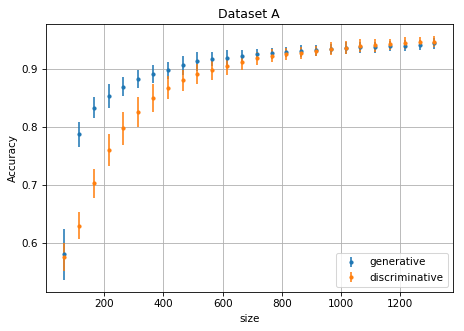

In [342]:
# ploting graph for dataset A

agen_mean = []
agen_size = []
agen_std = []

for size, accuracy_list in a_gen.items():
    agen_mean.append(stat.mean(accuracy_list))
    agen_std.append(stat.stdev(accuracy_list))
    agen_size.append(size)

adis_mean = []
adis_size = []
adis_std = []
for size, accuracy_list in a_dis.items():
    adis_mean.append(stat.mean(accuracy_list))
    adis_std.append(stat.stdev(accuracy_list))
    adis_size.append(size)
    
fig, ax = plt.subplots(nrows=1, ncols= 1)

fig.tight_layout(pad = 0.5, w_pad = 3, h_pad = 3)
ax.errorbar(agen_size, agen_mean, yerr = agen_std, fmt='.', label='generative')
ax.errorbar(adis_size, adis_mean, yerr = adis_std, fmt='.', label='discriminative')
ax.legend(loc='lower right')
#plt.rcParams['figure.dpi'] = 75 # default for me was 75
ax.set_ylabel('Accuracy')
ax.set_xlabel('size')
ax.set_title("Dataset A")
ax.grid(True)

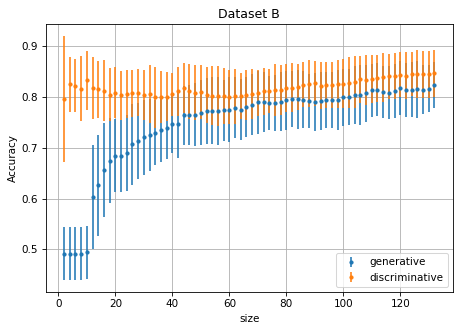

In [343]:
# ploting graph for dataset B

bgen_mean = []
bgen_size = []
bgen_std = []

for size, accuracy_list in b_gen.items():
    bgen_mean.append(stat.mean(accuracy_list))
    bgen_std.append(stat.stdev(accuracy_list))
    bgen_size.append(size)

bdis_mean = []
bdis_size = []
bdis_std = []
for size, accuracy_list in b_dis.items():
    bdis_mean.append(stat.mean(accuracy_list))
    bdis_std.append(stat.stdev(accuracy_list))
    bdis_size.append(size)
    
fig, ax = plt.subplots(nrows=1, ncols= 1)

fig.tight_layout(pad = 0.5, w_pad = 3, h_pad = 3)
ax.errorbar(bgen_size, bgen_mean, yerr = bgen_std, fmt='.', label='generative')
ax.errorbar(bdis_size, bdis_mean, yerr = bdis_std, fmt='.', label='discriminative')
ax.set_title("Dataset B")
ax.legend(loc='lower right')
#plt.rcParams['figure.dpi'] = 75 # default for me was 75
ax.set_ylabel('Accuracy')
ax.set_xlabel('size')
ax.grid(True)

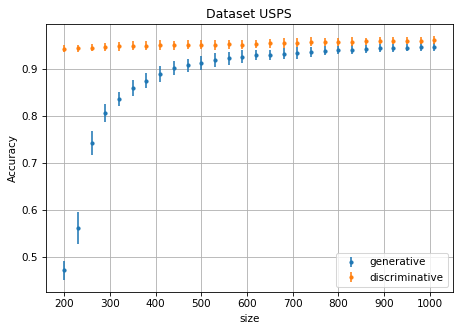

In [344]:
# ploting graph for dataset USPS

uspsgen_mean = []
uspsgen_size = []
uspsgen_std = []

for size, accuracy_list in usps_gen.items():
    uspsgen_mean.append(stat.mean(accuracy_list))
    uspsgen_std.append(stat.stdev(accuracy_list))
    uspsgen_size.append(size)

uspsdis_mean = []
uspsdis_size = []
uspsdis_std = []
for size, accuracy_list in usps_dis.items():
    uspsdis_mean.append(stat.mean(accuracy_list))
    uspsdis_std.append(stat.stdev(accuracy_list))
    uspsdis_size.append(size)
    
fig, ax = plt.subplots(nrows=1, ncols= 1)

fig.tight_layout(pad = 0.5, w_pad = 3, h_pad = 3)
ax.errorbar(uspsgen_size, uspsgen_mean, yerr = uspsgen_std, fmt='.', label='generative')
ax.errorbar(uspsdis_size, uspsdis_mean, yerr = uspsdis_std, fmt='.', label='discriminative')
ax.set_title("Dataset USPS")
ax.legend(loc='lower right')
ax.set_ylabel('Accuracy')
ax.set_xlabel('size')
ax.grid(True)

In your submission plot these results and discuss them: how do the algorithms perform on these
datasets? are there systematic differences? and how do the differences depend on training set size?

As a general trend accross all the dataset we observe that as the training set size increases the testing accuracy increase also the standard deviation shown by the error bar descreases.

Dataset A:
We observe that for dataset A, the generative model performs pretty well compared to the discriminative model for lower test size. As the test size increase, the difference between the 2 accuracies becomes smaller and smaller. 

A explaination for this is that, the dataset A is generated from a uniform distribution. Hence, the generative model fits pretty well on it as it satisifies the shared covariance matrix assumption made while defining the generative model. The data is linearly seperable and hence, 

Dataset B:
We observe that in dataset B, the accuracy is comparitive lesser. The generative model assumption doesn't completely hold true as the dataset is generated from multiple Gaussians with differing covariance structure.
Also, as the dataset is someone linearly sepearable, it was expected that the discriminative model will provide descent accuracy but it won't be really high as a line cannot perfectly fit. 

Dataset USPS:
Over here we observe that the discriminative model performs better than the generative model for very less dataset. However, as the data size increases both perform almost the same. 
The USPS is a real-life dataset and hence, the inputs can be really noisy. Hence, for small dataset size the generative model does not perform that well. As, the size of the trainset increases. The model is feed more examples and hence the overall noise descreases. 

Conclusion: 
We observe that which model performs better between generative and discrimative depends on the kind of data we are working on.

In [345]:
# this function calculates the wt vector using gradient ascent method

def gradient_ascent(X, t, learning_rate = 10**(-3)):
    start_time = time.time()
    time_vector = []
    alpha = 0.1

    w_old = np.zeros((np.shape(X)[1],1))
    time_vector.append((w_old, 0))
    b = np.dot(X, w_old)
    y = expit(b)
    w_new = w_old - (learning_rate*(np.dot(X.T, y - t) + alpha*w_old))
    time_vector.append((w_new, time.time() - start_time))
    n = 1
    while(((LA.norm(w_new - w_old) / LA.norm(w_old)) >= 10**(-3)) and (n <= 6000)):
        w_old = w_new
        b = np.dot(X, w_old)
        y = expit(b)
        w_new = w_old - (10**(-3)*(np.dot(X.T, y - t) + alpha*w_old))
        if(n%10 == 0):
            time_vector.append((w_new, time.time() - start_time))
        n+=1

    return w_new, time_vector

# TASK 2

C:\Users\rauna\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


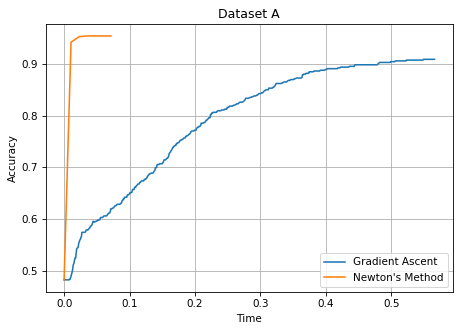

In [346]:
# to divide dataset into train and test
index = math.floor(len(A_X)/3)

X_vect = A_X[index::].reset_index( drop = True)
col = pd.DataFrame(np.ones((np.shape(X_vect)[0],1)))
X_vect['bias'] = col


# running 3 times to reduce the noise in time for gradient ascent
w, time_vector1 = gradient_ascent(X_vect.values,A_y[index::].reset_index( drop = True).values)
w, time_vector2 = gradient_ascent(X_vect.values, A_y[index::].reset_index(drop = True).values)
w, time_vector3 = gradient_ascent(X_vect.values ,A_y[index::].reset_index(drop = True).values)


A_test = A_X[0:index]
A_test.reset_index(inplace = True, drop = True)
col = pd.DataFrame(np.ones((np.shape(A_test)[0],1)))
A_test['bias'] = col
time_vals = []
error = []

for i in range(len(time_vector1)):
    y = expit(np.dot(A_test, time_vector1[i][0]))
    prob = [1 if a >= 0.5 else 0 for a in y]
    time_vals.append((time_vector1[i][1] + time_vector2[i][1] + time_vector3[i][1])/3) 
    error.append( accuracy_score(prob, A_y[0:index]))

# plotting the time vs accuracy for A
    
fig, ax = plt.subplots(nrows=1, ncols= 1)

fig.tight_layout(pad = 0.5, w_pad = 3, h_pad = 3)
ax.plot(time_vals, error, label = "Gradient Ascent")
ax.set_title("Dataset A")
ax.set_ylabel('Accuracy')
ax.set_xlabel('Time')
ax.grid(True )


# running 3 times to reduce the noise in time for Newton Method

w, time_vector1 = bayasian_logistic_reg(A_X[index::].reset_index(drop = True),A_y[index::].reset_index(drop = True))
w, time_vector2 = bayasian_logistic_reg(A_X[index::].reset_index(drop = True),A_y[index::].reset_index(drop = True))
w, time_vector3 = bayasian_logistic_reg(A_X[index::].reset_index(drop = True),A_y[index::].reset_index(drop = True))

time_vals = []
error = []

for i in range(len(time_vector1)):
    y = expit(np.dot(A_test, time_vector1[i][0]))
    prob = [1 if a >= 0.5 else 0 for a in y]
    time_vals.append((time_vector1[i][1] + time_vector2[i][1] + time_vector3[i][1])/3) 
    error.append(accuracy_score(prob, A_y[0:index]))

ax.plot(time_vals, error, label = "Newton's Method")
ax.legend(loc='lower right')


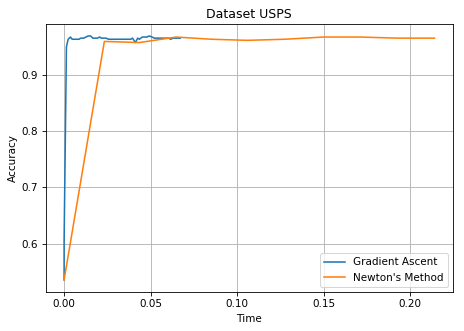

In [347]:
index = math.floor(len(usps_X)/3)


X_vect = usps_X[index::].reset_index(drop = True)
col = pd.DataFrame(np.ones((np.shape(X_vect)[0],1)))
X_vect['bias'] = col
X_vect = X_vect.values
y_vect = usps_y[index::].reset_index(drop = True).values

# running 3 times to reduce the noise in time for gradient ascent

w, time_vector1 = gradient_ascent(X_vect, y_vect)
w, time_vector2 = gradient_ascent(X_vect, y_vect)
w, time_vector3 = gradient_ascent(X_vect, y_vect)


usps_test = copy.deepcopy(usps_X[0:index])
usps_test.reset_index(inplace = True, drop = True)
col = pd.DataFrame(np.ones((np.shape(usps_test)[0],1)))
usps_test['bias'] = col



time_vals = []
error = []

for i in range(len(time_vector1)):
    y = expit(np.dot(usps_test, time_vector1[i][0]))
    prob = [1 if a >= 0.5 else 0 for a in y]
    time_vals.append((time_vector1[i][1] + time_vector2[i][1] + time_vector3[i][1])/3) 
    error.append(( accuracy_score(prob, usps_y[0:index])))

# plotting the time vs accuracy for usps
    
fig, ax = plt.subplots(nrows=1, ncols= 1)

fig.tight_layout(pad = 0.5, w_pad = 3, h_pad = 3)
ax.plot(time_vals, error, label = "Gradient Ascent")
ax.set_title("Dataset USPS")
ax.set_ylabel('Accuracy')
ax.set_xlabel('Time')
ax.grid(True )

# running 3 times to reduce the noise in time for Newton Method
    
w, time_vector1 = bayasian_logistic_reg(usps_X[index::].reset_index(drop = True),usps_y[index::].reset_index(drop = True))
w, time_vector2 = bayasian_logistic_reg(usps_X[index::].reset_index(drop = True), usps_y[index::].reset_index(drop = True))
w, time_vector3 = bayasian_logistic_reg(usps_X[index::].reset_index(drop = True), usps_y[index::].reset_index(drop = True))

time_vals = []
error = []

for i in range(len(time_vector1)):
    y = expit(np.dot(usps_test, time_vector1[i][0]))
    prob = [1 if a >= 0.5 else 0 for a in y]
    time_vals.append((time_vector1[i][1] + time_vector2[i][1] + time_vector3[i][1])/3) 
    error.append((accuracy_score(prob, usps_y[0:index])))

ax.plot(time_vals, error, label = "Newton's Method")
ax.legend(loc='lower right')


how do the algorithms perform on these
datasets? are there systematic differences? and how do the differences depend on data set charac-
teristics?

We observe that gradient descent is really slow on the Dataset A and Newton's Method seems to converge pretty quickly.
For dataset USPS, gradient descent is slightly quicker than Newton's Method. 

An explaination for this is that the Newton' Method involve computing the inverse of the Hessian Matrix. This is a very expensive operation and requires time complexity O(n^3). 
So, for a dataset with a lot of features, The Hessian inverse compution will be really expensive. 
Even, though Newton's Method usually converges in lesser number of steps the overall time taken by Newton's Method can be higher than that taken by Gradient descent due to Hessian inverse computation overhead.

There are lesser features in A compared to USPS and hence Newton's method performs better on A. While gradient descent performs better on USPS.

# EXTRA CREDITS

In [348]:
def s_gradient_ascent(X, t, iterations, batch_size, learning_rate = 10**(-3)):
    start_time = time.time()
    time_vector = []
    alpha = 0.1

    w_old = np.zeros((np.shape(X)[1],1))
    time_vector.append((w_old, 0))
    B_X_train, X_new, B_y_train, t_new = train_test_split(X, t, test_size=(batch_size/len(X)))
    
    #print(np.shape(X_new))
    #print(np.shape(w_old))
    b = np.dot(X_new, w_old)
    y = expit(b)
    
    
    prod = np.dot(X_new.T, y - t_new)
    w_new = w_old -  learning_rate*(prod + alpha*w_old)

    time_vector.append((w_new, time.time() - start_time))
    n = 1
    while(n <= iterations):
        w_old = w_new
        i = random.randint(0, len(X) -1)
        B_X_train, X_new, B_y_train, t_new = train_test_split(X, t, test_size=(batch_size/len(X)))
        #X_new = np.reshape(X[i], (1, np.shape(X[i])[0]))
        b = np.dot(X_new, w_old)
        y = expit(b)
        learning_rate = 1/n
        w_new = w_old - learning_rate*(np.dot(X_new.T, y - t_new) + alpha*w_old)
        if(n%10 == 0):
            time_vector.append((w_new, time.time() - start_time))
        n+=1

    return w_new, time_vector

C:\Users\rauna\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,16.0417,'Time')

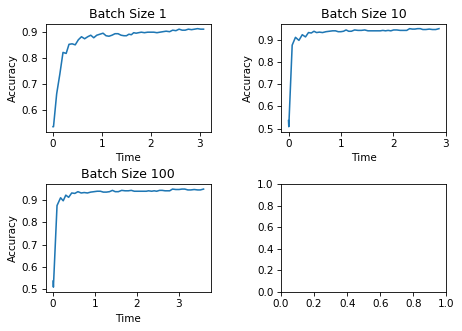

In [349]:
index = math.floor(len(usps_X)/3)

X_vect = usps_X[index::].reset_index(drop = True)
col = pd.DataFrame(np.ones((np.shape(X_vect)[0],1)))
X_vect['bias'] = col
X_vect = X_vect.values
y_vect = usps_y[index::].reset_index(drop = True).values

start_t = time.time()
w, time_vector1 = s_gradient_ascent(X_vect, y_vect, 500, 1)
w, time_vector2 = s_gradient_ascent(X_vect, y_vect, 500, 10)
w, time_vector3 = s_gradient_ascent(X_vect, y_vect, 500, 100)



A_test = usps_X[0:index]
A_test.reset_index(inplace = True, drop = True)
col = pd.DataFrame(np.ones((np.shape(usps_test)[0],1)))
A_test['bias'] = col
time_vals1 = []
error1 = []

time_vals2 = []
error2 = []

time_vals3 = []
error3 = []

for i in range(len(time_vector1)):
    #print(i)
    y = expit(np.dot(A_test, time_vector1[i][0]))
    prob = [1 if a >= 0.5 else 0 for a in y]
    time_vals1.append(time_vector1[i][1]) 
    error1.append( accuracy_score(prob, usps_y[0:index]))

for i in range(len(time_vector2)):
    #print(i)
    y = expit(np.dot(A_test, time_vector2[i][0]))
    prob = [1 if a >= 0.5 else 0 for a in y]
    time_vals2.append(time_vector2[i][1]) 
    error2.append( accuracy_score(prob, usps_y[0:index]))
    
for i in range(len(time_vector3)):
    #print(i)
    y = expit(np.dot(A_test, time_vector3[i][0]))
    prob = [1 if a >= 0.5 else 0 for a in y]
    time_vals3.append(time_vector3[i][1]) 
    error3.append( accuracy_score(prob, usps_y[0:index]))

    
fig, ax = plt.subplots(nrows=2, ncols= 2)

fig.tight_layout(pad = 0.5, w_pad = 3, h_pad = 3)
ax[0][0].plot(time_vals1, error1, label = "Batch size 1")
ax[0][1].plot(time_vals2, error2, label = "Batch size 10")
ax[1][0].plot(time_vals3, error2, label = "Batch size 100")

ax[0][0].set_title("Batch Size 1")
ax[0][1].set_title("Batch Size 10")
ax[1][0].set_title("Batch Size 100")
#plt.rcParams['figure.dpi'] = 75 # default for me was 75
ax[0][0].set_ylabel('Accuracy')
ax[0][0].set_xlabel('Time')

ax[0][1].set_ylabel('Accuracy')
ax[0][1].set_xlabel('Time')

ax[1][0].set_ylabel('Accuracy')
ax[1][0].set_xlabel('Time')


The stochatic gradient descent seems to give a good enough accuracy in reasonable iterations. However, the updates are very noisy. 

This is because, the gradient update is calculate by the error on only example. 

In order to reduce this noisy update, I have implemented a mini-batch gradient descent. 

We observe that as the batch size increase the updates become less noisy.
However, with increasing batch size the training time also increases. 

Therefore, there is a trade-off between the between less noisy convergence and the time taken. 

The stochastic gradient descent can be considered as a special case of mini-batch gradient descent with batch size = 1. 
This gives us a noisy update. 

The batch gradient descent is mini-batch GD where the batch size is the entore dataset. This can be really slow on data where there are large number of samples. 

Hence, we have to give a mini-batch size such it gives us the best of both the world. A good update with less noise in reasonable time.

C:\Users\rauna\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


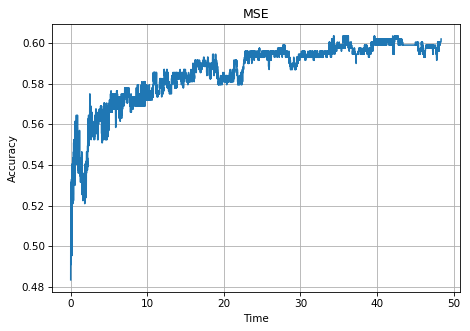

In [350]:
index = math.floor(len(A_X)/3)

X_vect = A_X[index::].reset_index(drop = True)
col = pd.DataFrame(np.ones((np.shape(X_vect)[0],1)))
X_vect['bias'] = col
X_vect = X_vect.values
y_vect = A_y[index::].reset_index(drop = True).values

start_t = time.time()
w, time_vector3 = s_gradient_ascent(X_vect, y_vect, 100000, 1)


A_test = A_X[0:index]
A_test.reset_index(inplace = True, drop = True)
col = pd.DataFrame(np.ones((np.shape(A_test)[0],1)))
A_test['bias'] = col

time_vals = []
error = []

for i in range(len(time_vector3)):
    y = expit(np.dot(A_test, time_vector3[i][0]))
    prob = [1 if a >= 0.5 else 0 for a in y]
    time_vals.append(time_vector3[i][1]) 
    error.append(accuracy_score(prob, A_y[0:index]))


fig, ax = plt.subplots(nrows=1, ncols= 1)

fig.tight_layout(pad = 0.5, w_pad = 3, h_pad = 3)
ax.plot(time_vals, error)
ax.set_title("MSE")
#plt.rcParams['figure.dpi'] = 75 # default for me was 75
ax.set_ylabel('Accuracy')
ax.set_xlabel('Time')
ax.grid(True)

We observe that the stochastic gradient descent is really slow to compared to gradient descent. This is because, SGD only gives performance boost if the data size is large. For smaller data sizes, it doesn't have much of an advantage and can be slower and time because the update based on single example could take us further away from the optimal solution. 

All, there is a significant overhead in SGD and mini-batch GD of randomly sampling examples from the dataset. This could be an expensive operation. The overhead isn't really worth for small datasets like the one's we have experimented on. (A and USPS).
